<a href="https://colab.research.google.com/github/nabeel-gulzar/CodeCloneDetection/blob/main/CodeT5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install transformers

In [8]:
# !gsutil
# !gsutil cp gs://sfr-codet5-data-research/finetuned_models/clone_codet5_base.bin /content/drive/MyDrive/model-ckpts/codet5-ccd

Copying gs://sfr-codet5-data-research/finetuned_models/clone_codet5_base.bin...
\ [1 files][850.4 MiB/850.4 MiB]   47.7 MiB/s                                   
Operation completed over 1 objects/850.4 MiB.                                    


In [2]:
import torch
from transformers import RobertaTokenizer, T5ForConditionalGeneration, T5Config, T5Tokenizer

In [19]:
ckpt_path = "/content/drive/MyDrive/model-ckpts/codet5-ccd/clone_codet5_base.bin"

In [73]:
# base_model = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-base')
# tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')

In [86]:
# input_ids = tokenizer("text", return_tensors="pt")

In [3]:
# input_ids.input_ids.size()

In [4]:
import torch.nn as nn

In [5]:
class RobertaClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size * 2, config.hidden_size)
        self.out_proj = nn.Linear(config.hidden_size, 2)

    def forward(self, x, **kwargs):
        x = x.reshape(-1, x.size(-1) * 2)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.out_proj(x)
        return x

In [6]:
class CloneModel(nn.Module):
    def __init__(self, encoder, config, tokenizer, args):
        super(CloneModel, self).__init__()
        self.encoder = encoder
        self.config = config
        self.tokenizer = tokenizer
        self.classifier = RobertaClassificationHead(config)
        self.args = args

    def get_t5_vec(self, source_ids):
        attention_mask = source_ids.ne(self.tokenizer.pad_token_id)
        outputs = self.encoder(input_ids=source_ids, attention_mask=attention_mask,
                               labels=source_ids, decoder_attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs['decoder_hidden_states'][-1]
        eos_mask = source_ids.eq(self.config.eos_token_id)

        if len(torch.unique(eos_mask.sum(1))) > 1:
            raise ValueError("All examples must have the same number of <eos> tokens.")
        vec = hidden_states[eos_mask, :].view(hidden_states.size(0), -1,
                                              hidden_states.size(-1))[:, -1, :]
        return vec

    # def get_bart_vec(self, source_ids):
    #     attention_mask = source_ids.ne(self.tokenizer.pad_token_id)
    #     outputs = self.encoder(input_ids=source_ids, attention_mask=attention_mask,
    #                            labels=source_ids, decoder_attention_mask=attention_mask, output_hidden_states=True)
    #     hidden_states = outputs['decoder_hidden_states'][-1]
    #     eos_mask = source_ids.eq(self.config.eos_token_id)

    #     if len(torch.unique(eos_mask.sum(1))) > 1:
    #         raise ValueError("All examples must have the same number of <eos> tokens.")
    #     vec = hidden_states[eos_mask, :].view(hidden_states.size(0), -1,
    #                                           hidden_states.size(-1))[:, -1, :]
    #     return vec

    # def get_roberta_vec(self, source_ids):
    #     attention_mask = source_ids.ne(self.tokenizer.pad_token_id)
    #     vec = self.encoder(input_ids=source_ids, attention_mask=attention_mask)[0][:, 0, :]
    #     return vec

    def forward(self, source_ids=None, labels=None):
        source_ids = source_ids.view(-1, self.args["max_source_length"])

        vec = self.get_t5_vec(source_ids)

        # if self.args.model_type == 'codet5':
        #     vec = self.get_t5_vec(source_ids)
        # elif self.args.model_type == 'bart':
        #     vec = self.get_bart_vec(source_ids)
        # elif self.args.model_type == 'roberta':
        #     vec = self.get_roberta_vec(source_ids)

        logits = self.classifier(vec)
        prob = nn.functional.softmax(logits)

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            return loss, prob
        else:
            return prob

In [103]:
config_class, model_class, tokenizer_class = (T5Config, T5ForConditionalGeneration, RobertaTokenizer)
config = config_class.from_pretrained("Salesforce/codet5-base")
model = model_class.from_pretrained("Salesforce/codet5-base")
tokenizer = tokenizer_class.from_pretrained("Salesforce/codet5-base")

In [104]:
model = CloneModel(model, config, tokenizer, {"max_source_length": 400})

In [ ]:
device = torch.device("cuda")
model.to(device)

In [89]:
from torch.utils.data import DataLoader
from sklearn.metrics import recall_score, precision_score, f1_score

In [106]:
class CloneExample(object):
    """A single training/test example."""

    def __init__(self,
                 code1,
                 code2,
                 label,
                 url1,
                 url2
                 ):
        self.source = code1
        self.target = code2
        self.label = label
        self.url1 = url1
        self.url2 = url2

In [107]:
import numpy as np
from torch.utils.data import SequentialSampler
from tqdm.notebook import tqdm

In [108]:
def evaluate(model, eval_examples, eval_data):
    eval_sampler = SequentialSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=10)

    # Eval!
    # logger.info("***** Running evaluation  *****")
    # logger.info("  Num examples = %d", len(eval_examples))
    # logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()
    logits = []
    y_trues = []
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader), desc="Evaluating"):
        inputs = batch[0].to(device)
        labels = batch[1].to(device)
        with torch.no_grad():
            lm_loss, logit = model(inputs, labels)
            eval_loss += lm_loss.mean().item()
            logits.append(logit.cpu().numpy())
            y_trues.append(labels.cpu().numpy())
        nb_eval_steps += 1
    logits = np.concatenate(logits, 0)
    y_trues = np.concatenate(y_trues, 0)
    best_threshold = 0.5

    y_preds = logits[:, 1] > best_threshold
    recall = recall_score(y_trues, y_preds)
    precision = precision_score(y_trues, y_preds)
    f1 = f1_score(y_trues, y_preds)
    result = {
        "eval_recall": float(recall),
        "eval_precision": float(precision),
        "eval_f1": float(f1),
        "eval_threshold": best_threshold,
    }

    # print("***** Eval results *****")
    # for key in sorted(result.keys()):
    #     print("  %s = %s", key, str(round(result[key], 4)))
    # logger.info("  " + "*" * 20)

    # if write_to_pred:
    #     with open(os.path.join(args.output_dir, "predictions.txt"), 'w') as f:
    #         for example, pred in zip(eval_examples, y_preds):
    #             if pred:
    #                 f.write(example.url1 + '\t' + example.url2 + '\t' + '1' + '\n')
    #             else:
    #                 f.write(example.url1 + '\t' + example.url2 + '\t' + '0' + '\n')

    return result


In [109]:
class CloneInputFeatures(object):
    """A single training/test features for a example."""

    def __init__(self,
                 example_id,
                 source_ids,
                 label,
                 url1,
                 url2
                 ):
        self.example_id = example_id
        self.source_ids = source_ids
        self.label = label
        self.url1 = url1
        self.url2 = url2

In [110]:
def convert_clone_examples_to_features(item):
    example, example_index, tokenizer = item
    # if args.model_type in ['t5', 'codet5'] and args.add_task_prefix:
    #     source_str = "{}: {}".format(args.task, example.source)
    #     target_str = "{}: {}".format(args.task, example.target)
    # else:
    source_str = example.source
    target_str = example.target
    code1 = tokenizer.encode(source_str, max_length=400, padding='max_length', truncation=True)
    code2 = tokenizer.encode(target_str, max_length=400, padding='max_length', truncation=True)
    source_ids = code1 + code2
    return CloneInputFeatures(example_index, source_ids, example.label, example.url1, example.url2)


In [111]:
import json

In [96]:
lens = []
with open("/content/data.jsonl") as f:
    for line in f:
        line = line.strip()
        js = json.loads(line)
        code = js['func'].split()
        lens.append(len(code))

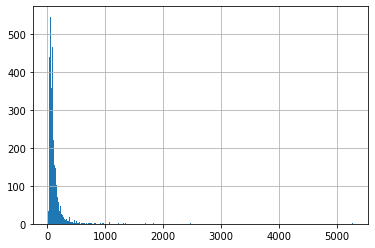

In [97]:
import pandas as pd
pd.Series(lens).hist(bins = 1000)

In [112]:
def read_clone_examples(filename="/content/valid.txt"):
    """Read examples from filename."""
    index_filename = filename
    url_to_code = {}
    with open('/'.join(index_filename.split('/')[:-1]) + '/data.jsonl') as f:
        for line in f:
            line = line.strip()
            js = json.loads(line)
            code = ' '.join(js['func'].split())
            url_to_code[js['idx']] = code

    data = []
    with open(index_filename) as f:
        # idx = 0
        for line in f:
            line = line.strip()
            url1, url2, label = line.split('\t')
            if url1 not in url_to_code or url2 not in url_to_code:
                continue
            if label == '0':
                label = 0
            else:
                label = 1
            data.append(CloneExample(url_to_code[url1], url_to_code[url2], label, url1, url2))
            # idx += 1
            # if idx == data_num:
            #     break
    return data

In [99]:
from torch.utils.data import TensorDataset

In [113]:
def load_and_cache_clone_data(filename, tokenizer):
    # cache_fn = '{}/{}.pt'.format(args.cache_path, split_tag + '_all' if args.data_num == -1 else '_%d' % args.data_num)
  examples = read_clone_examples(filename)
    # if is_sample:
    #     examples = random.sample(examples, int(len(examples) * 0.1))

    # calc_stats(examples, tokenizer, is_tokenize=True)
    # if os.path.exists(cache_fn):
    #     logger.info("Load cache data from %s", cache_fn)
    #     data = torch.load(cache_fn)
    # else:
      # if is_sample:
      #     logger.info("Sample 10 percent of data from %s", filename)
      # elif args.data_num == -1:
      #     logger.info("Create cache data into %s", cache_fn)
  tuple_examples = [(example, idx, tokenizer) for idx, example in enumerate(examples)]
  features = list(map(convert_clone_examples_to_features, tuple_examples))
  # features = pool.map(convert_clone_examples_to_features, tqdm(tuple_examples, total=len(tuple_examples)))
  all_source_ids = [f.source_ids for f in features]
  # print(f"source IDs: {len(all_source_ids)}")
  all_source_ids = torch.tensor(all_source_ids, dtype=torch.long)

  all_labels = [f.label for f in features]
  # print(f"all labels: {len(all_labels)}")
  all_labels = torch.tensor(all_labels, dtype=torch.long)

  # data = None
  data = TensorDataset(all_source_ids, all_labels)
  

  # if args.local_rank in [-1, 0] and args.data_num == -1:
  #     torch.save(data, cache_fn)
  return examples, data

In [114]:
eval_examples, eval_data = load_and_cache_clone_data("/content/test_small.txt", tokenizer)

In [116]:
eval_data

In [117]:
result = evaluate(model, eval_examples, eval_data)

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [118]:
print("  test_f1=%.4f", result['eval_f1'])
print("  test_prec=%.4f", result['eval_precision'])
print("  test_rec=%.4f", result['eval_recall'])
print("  " + "*" * 20)

  test_f1=%.4f 0.2452107279693487
  test_prec=%.4f 0.1671018276762402
  test_rec=%.4f 0.460431654676259
  ********************


In [ ]:
# base_model = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-base')
# tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')

In [74]:
# param_dict = torch.load(ckpt_path)
# model.load_state_dict(param_dict)

In [75]:
# pred = model.generate(**diff)
# print(tokenizer.decode(pred[0], skip_special_tokens=True))

In [76]:
# generated_ids = base_model.generate(**diff, max_length=8)
# print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))

In [77]:
# tokenizer.decode(generated_ids[0], skip_special_tokens=True)